# 10-714: Homework 1

In this homework you will build the basics of a reverse mode automatic differentiation engine which we will refer to as __needle__ (__ne__cessary __e__lements of __d__eep __le__arning). Before we dive into the code, let's setup the connection to Drive just as we did for homework 0, and install any necessary packages. To get started, make a copy of this notebook file by selecting "Save a copy in Drive" from the "File" menu, and then run the code block below.

In [ ]:
Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
!git clone https://github.com/dlsys10714/hw1.git
%cd /content/drive/MyDrive/10714/hw1

!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
!pip3 install numdifftools

In [ ]:
import sys
sys.path.append('./python')
sys.path.append('./apps')
from simple_ml import *

## Introduction to `needle`

Our framework is called `needle`. Needle stands for **ne**cessary **e**lements of **d**eep **le**arning.
You can also viewed it as a sewing needle that threads through clothes to form (neural)net patterns, and the create traces for automatic differentiation.

The `needle` framework is set up with the following files: 

- `python/needle`
    - `__init__.py`
    - `auograd.py`
    - `device.py`
    - `numpy_backend.py`
    - `ops.py`


### Tensor creation and manipulation


In [ ]:
import needle as ndl
x = ndl.Tensor([1, 2, 3], dtype="float32")
print(type(x))
x

We can call perform array operations on `needle Tensors`. The following code creates a new `Tensor` `y` by adding a constant scalar to `x`.

In [ ]:
y = ndl.add_scalar(x, 1)
y

We provide common operator overloadings so you can also directly write `+` and the call redirects to `ndl.add_scalar`.

In [ ]:
y = x + 1
y

We can call `y.numpy()` to explicitly convert a `needle Tensor` to a `numpy ndarray`. Note for numpy backend, needle tensor is backed by an numpy.ndarray so there isn't much a difference here. However, we will implement other non-numpy backends that are backed by different kind of devices.

In [ ]:
y.numpy()

### Key Data Structures

`needle` contains the following key data structures:

- `Value`: represent a value "node" in a computational graph
    - `Tensor` is a subclass of `Value`.
    - We might introduce other kinds of `Value` in the future (e.g. tuple of tensors)
- `Op`: represent the kind of computation we perform at each node.
- `Device`: abstraction of the backend device and computation engine.

There are two common ways to extend a deep learning system:
- Add new operators
- Add new "execution backend" 


## Computational Graph

When running array computations, `needle` not only executes the arithmetic operations, but also creates a computational graph along the way. For example, consider the following computation:

In [ ]:
v1 = ndl.Tensor([0], dtype="float32")
v2 = ndl.exp(v1)
v3 = v2 + 1
v4 = v2 * v3

This code block constructs the following computational graph:

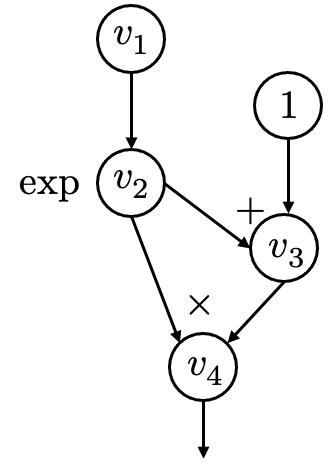

`v4.inputs` contains the input values to the operation

In [ ]:
v4.inputs

We further confirm that `v4.inputs == [v2, v3]`

In [ ]:
v4.inputs[0] is v2 and v4.inputs[1] is v3

Besides the inputs field, `v4` also contains an `op` field that records the operation performed. In this case the operation is `EWiseMulOp`.

In [ ]:
v4.op

`v3` is an add scalar node that represents a constant scalar add to an input. `

In [ ]:
v3.op

We can see that `v3` only has one input: `v2`.

In [ ]:
v3.inputs

`v3` also contains an `attrs` field that stores the scalar constant:

In [ ]:
v3.attrs

## Executing the Computation

Now let us take a deeper look at what happens when we run an array operation.
Specifically, what happens when we run `ndl.multiply`:

In [ ]:
x1 = ndl.Tensor([3], dtype="float32")
x2 = ndl.Tensor([4], dtype="float32")
x3 = x1 * x2

Open up the code browser, check the following functions along the calling path:
- `ops.EWiseMul.__call__` calls into
- `autograd.Tensor.make_from_op` calls into
- `autograd.Tensor.realize_cached_data` calls into
- `NumpyDevice.compute` calls into 
- `x3.op.numpy_compute`, which is a registered attribute on this op

A few key points to note here:
- `make_from_op` constructs the computational graph node. 
- The actual computation won't happen until `realize_cached_data` is called.
- The `cached_data` field and computation can be backend (device) specific. 
- Right now `NumpyDevice` is the default
- We use a registry pattern to register a specific computation for a given backend.


In [ ]:
type(x3.device)

The following code helps us to find the location of the original compute function being registered.

In [ ]:
x3.op.numpy_compute.__code__

For `numpy` backend, each `Value` node stores a `cached_data` field that corresponds to the computed data. Because we are using `numpy` backend now, the `cached_data` is a `numpy.ndarray`.

In [ ]:
type(x3.cached_data)

In [ ]:
x3.cached_data

### Lazy Evaluation

We also support a lazy evaluation mode. In this case, we do not compute `cached_data` right away. But `cached_data` will be computed once we need the actual result (when we call `x3.data`, `x3.numpy()`, etc.).


In [ ]:
ndl.autograd.LAZY_MODE = True
x1 = ndl.Tensor([3], dtype="float32")
x2 = ndl.Tensor([4], dtype="float32")
x3 = x1 * x2

We can see that `x3`'s `cached_data` field is not yet readily available. But as soon as we call `x3.numpy()`, a call to `x3.realize_cached_data()` will get triggered to compute the actual value.

In [ ]:
x3.cached_data is None

In [ ]:
x3.numpy()
x.cached_data

By default we use eager evaluation mode that always directly realizes the computation, but lazy evaluation can also be helpful for some advanced optimizations later.

In [ ]:
ndl.autograd.LAZY_MODE = False

## Question 1: Implementing forward computation [10 pts]

First, let's implement forward computation in our computation graph. Consider a function like `add_scalar` which would add a scalar to a `Tensor`. 

Let's take a look at the function `add_scalar` for the `numpy` backend in `python/needle/numpy_backend.py`:
```python
@register_numpy_compute("AddScalar")
def add_scalar(inputs, attrs):
    assert len(inputs) == 1
    return np.add(inputs[0], attrs["scalar"])
```

Note that each function in `python/needle/numpy_backend.py` has the arguments `inputs`, which is a list of, in this case, `numpy` arrays, and `attrs`, which is a dictionary of additional arguments to the function.

To start, implement and test (with the following code cell) the forward passes of following operators in `python/needle/numpy_backend.py`. Note that these should all be straightforward, and nearly all will be one line calls to the equivalent `numpy` function. We've included below the arguments to each function in parentheses, i.e. the number of input arrays in the list `inputs`, and the keys and name/type of any additional keyword arguments in the dictionary `attrs`.

- `divide`: true division of the inputs, element-wise (2 inputs)
- `divide_scalar`: true division of the input by a scalar, element-wise (1 input, `scalar` - number)
- `matmul`: matrix multiplication of the inputs (2 inputs)
- `summation`: sum of array elements over given axes (1 input, `axes` - tuple)
- `broadcast_to`: broadcast an array to a new shape (1 input, `shape` - tuple)
- `reshape`: gives a new shape to an array without changing its data (1 input, `shape` - tuple)
- `negate`: numerical negative, element-wise (1 input)
- `transpose`: reverse or permute the axes of an array; returns the modified array (1 input, `axes` - tuple)

In [ ]:
!python3 -m pytest -v -k "forward"

In [ ]:
!python3 -m mugrade submit 'YOUR_GRADER_KEY_HERE' -k "forward"

## Question 2: Implementing backward computation [25 pts]

Now that you have implemented the functions within our computation graph, in order to implement automatic differentiation using our computational graph, we need to be able to multiply by the Jacobian of the function with respect to its input. 

Recall that to compute the Jacobian $\frac{\partial \ell}{\partial x}$ for some scalar valued function $\ell$, we just need to multiply the Jacobian $\frac{\partial \ell}{\partial z}$ by the functions "local" Jacobian $\frac{\partial f(x,y)}{\partial x}$:
\begin{equation}
\frac{\partial \ell}{\partial x} = \frac{\partial \ell}{\partial z} \frac{\partial f(x,y)}{\partial x}.
\end{equation}

Our `backwards` call thus will compute this Jacobian-vector product. Assuming in the above example that $x \in \mathbb{R}^m$ and $z \in \mathbb{R}^n$, then e.g., $\frac{\partial \ell}{\partial z}$ is an $n$-dimensional row vector.  It's more common to deal with the tranpose of these Jacobians $(\frac{\partial \ell}{\partial z})^T$, which is exactly what we defined as the gradient $\nabla_z \ell$; the advantage of this quantity is that these gradients are always exactly the same size as the output vector, i.e., if $z \in \mathbb{R}^n$, then $\nabla_z \ell \in \mathbb{R}^n$ as well.  The update equation in terms of the gradients thus reduces to multiplying by the _transpose_ of the Jacobian

\begin{equation}
\nabla_x \ell = \left(\frac{\partial f(x,y)}{\partial x}\right)^T \nabla_z \ell.
\end{equation}

Let's take the simple example of the addition function $f(x,y) = x+y$. Then, in this case we have,
\begin{equation}
\frac{\partial f(x,y)}{\partial x} = \frac{\partial x}{\partial x} = I.
\end{equation}

And so, we have the following expression
\begin{equation}
\nabla_x \ell = I \nabla_z \ell = \nabla_z \ell, \;\; \mbox{(and similarly $\nabla_y \ell = \nabla_z \ell$)}.
\end{equation}

Let's see how we would implement this in the `needle` framework. Take a look at the `EWiseAddOp` class from `python/needle/ops.py`: 

```python
class EWiseAddOp(Op):
    def __call__(self, a: Tensor, b: Tensor) -> Tensor:
        return Tensor.make_from_op(self, [a, b])

    def gradient(self, out_grad, node):
        return [out_grad, out_grad]
```

This is then be connected to the forward method, as follows:

```python
add = register_op("EWiseAdd", EWiseAddOp())
```

In [ ]:
v1 = ndl.Tensor([0], dtype="float32")
v2 = ndl.Tensor([1], dtype="float32")
v3 = v1 + v2
in_grads = v3.op.gradient(ndl.Tensor([1], dtype="float32"), v3)
in_grads

Let's consider another example, the (elementwise) multiplication function
\begin{equation}
f(x,y) = x \circ y
\end{equation}
where $\circ$ denotes elementwise multiplication between $x$ and $y$.  The Jacobian of this function is given by
\begin{equation}
\frac{\partial f(x,y)}{\partial x} = \mathrm{diag}(y)
\end{equation}
so that
\begin{equation}
\nabla_x \ell = \mathrm{diag}(y) \nabla_z \ell = y \circ \nabla_z \ell, \;\; \mbox{(and similarly $\nabla_y \ell = x \circ \nabla_z \ell$).}
\end{equation}

Let's look at the `EWiseMulOp` class from `python/needle/ops.py`: 

```python
class EWiseMulOp(Op):
    """Op to element-wise multiply two nodes."""

    def __call__(self, a: Tensor, b: Tensor) -> Tensor:
        return Tensor.make_from_op(self, [a, b])

    def gradient(self, out_grad, node):
        lhs, rhs = node.inputs
        return (out_grad * rhs, out_grad * lhs)
    
multiply = register_op("EWiseMul", EWiseMulOp())
```


In [ ]:
v1 = ndl.Tensor([6], dtype="float32")
v2 = ndl.Tensor([7], dtype="float32")
v3 = v1 * v2
in_grads = v3.op.gradient(ndl.Tensor([1], dtype="float32"), v3)
in_grads

### Implementing backward passes

Note that, unlike the forward pass functions, the arguments to the `gradient` function are `needle` objects. It is important to implement the backward passes using only `needle` operations. 

To complete this question, fill in the `gradient` function of the following classes:

- `EWiseDivOp`
- `DivScalarOp`
- `MatMulOp`
- `SummationOp`
- `BroadcastToOp`
- `ReshapeOp`
- `NegateOp`
- `TransposeOp`

All of the `gradient` functions can be computed using just the operations defined in `python/needle/ops.py`, so there is no need to define any additional forward functions.

### Checking backward passes
Note that we can check that these backward passes are correct by using numerical differentiation to evaluate the gradient via finite difference.  From basic calculus we know that
\begin{equation}
\frac{d f(x)}{dx} = \lim_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h},
\end{equation}
so we can just evaluate the function at two different values for a very small value of $h$, and this forms an approximation of the gradient. We provide the function `backward_check` for doing this numerical checking in `tests/test_autograd.py`.

In [ ]:
!python3 -m pytest -l -v -k "backward"

In [ ]:
!python3 -m mugrade submit 'YOUR_GRADER_KEY_HERE' -k "backward"

## Question 3: Topological sort [20 pts]

Now your system is capable of performing operations on tensors which builds up a computation graph. Now we will write one of the main utilities needed for automatic differentiation - the [topological sort](https://en.wikipedia.org/wiki/Topological_sorting). This will allow us to traverse through (forward or backward) the compuatation graph, computing gradients along the way. Furthermore, the previously built components will allow for the operations we perform during this reverse topological traversal to further add to our computation graph (as discussed in lecture), and will therefore give us higher-order differentiation "for free." 

Fill out the `find_topo_sort` method and the `topo_sort_dfs` helper method (in `python/needle/autograd.py`) to perform this topological sorting. 

#### Hints: 
- Ensure that you do a post-order depth-first search, otherwise the test cases will fail. 
- The `topo_sort_dfs` method is not required, but we find it useful to use this as a recursive helper function. 
- The "Reverse mode AD by extending computational graph" section of the Lecture 4 slides contains walks through an example of the proper node ordering. 
- We will be traversing this sorting backwards in later parts of this homework, but the `find_topo_sort` should return the node ordering in the forward direction. 

In [ ]:
!python3 -m pytest -k "topo_sort"

In [ ]:
!python3 -m mugrade submit 'YOUR_GRADER_KEY_HERE' -k "topo_sort"

## Question 4: Implementing reverse mode differentiation [25 pts]

Once you have correctly implemented the topological sort, let's leverage it to implement reverse mode automatic differentiation. As a recap from last lecture, we will need to traverse the computational graph in reverse topological order, and construct the new adjoint nodes (`Tensors`).

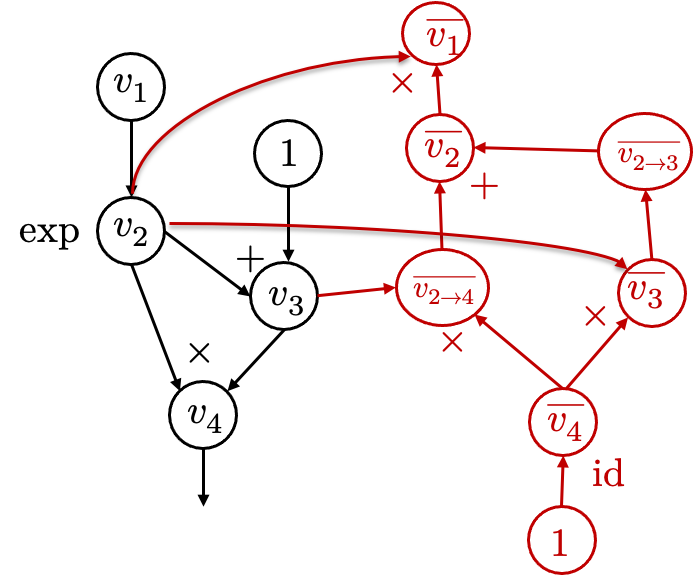

For this question, implement the Reverse AD algorithm in the `compute_gradient_of_variables` function in `python/needle/autograd.py` to enable the `backward` function that computes the gradient and stores the gradient in the `grad` field of each input `Tensor`. With this completed, our reverse model autodifferentiation engine is functional. 

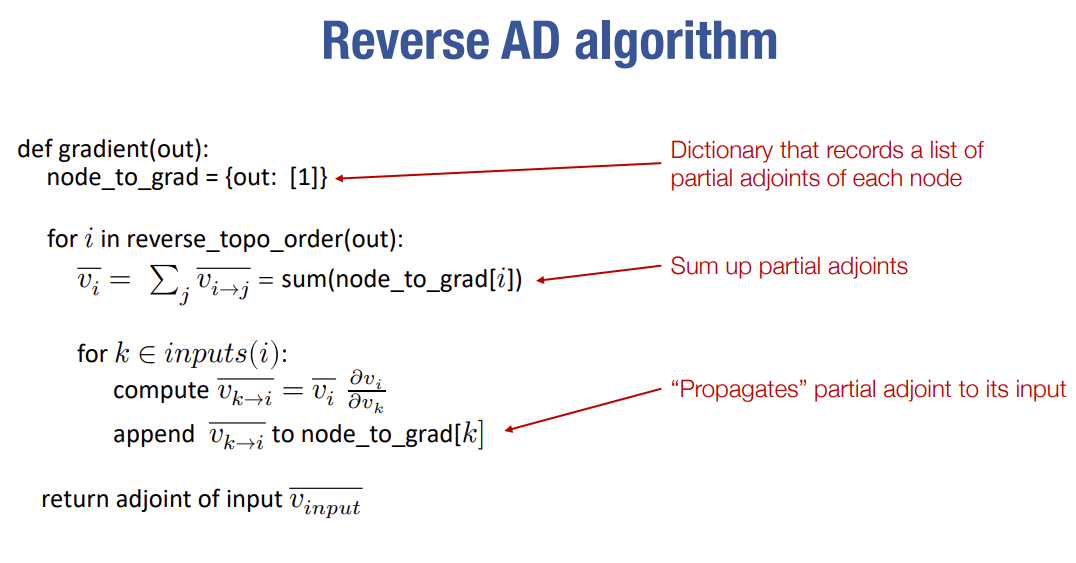

As discussed in lecture the result of reverse mode AD is still a computational graph. We can extend that graph further by composing more operations and run reverse mode AD again on the gradient (the last two tests of this problem). 

In [ ]:
!python3 -m pytest -k "compute_gradient"

In [ ]:
!python3 -m mugrade submit 'YOUR_GRADER_KEY_HERE' -k "compute_gradient"

## Question 5: Softmax loss [10 pts]

The following questions will be tested using the MNIST dataset, so we will use the `parse_mnist` function we wrote in the Homework 0. 

1. First, copy and paste your solution to Question 2 of Homework 0 to the `parse_mnist` function in the `apps/simple_ml.py` file.  

In this question, you will implement the softmax loss as defined in the `softmax_loss()` function in `apps/simple_ml.py`, which we defined in Question 3 of Homework 0, except this time, the softmax loss takes as input a `Tensor` of logits and a `Tensor` of one hot encodings of the true labels. As a reminder, for a multi-class output that can take on values $y \in \{1,\ldots,k\}$, the softmax loss takes as input a vector of logits $z \in \mathbb{R}^k$, the true class $y \in \{1,\ldots,k\}$ (which is encoded for this function as a one-hot-vector) returns a loss defined by
\begin{equation}
\ell_{\mathrm{softmax}}(z, y) = \log\sum_{i=1}^k \exp z_i - z_y.
\end{equation}

You will first need to implement the forward and backward passes of two additional operators: ``log`` and ``exp``. 

2. Fill out the functions `log`, and `exp` in `python/needle/numpy_backend.py`.
3. Fill out the `gradient` function of the classes `LogOp` and `ExpOp` in `python/needle/ops.py`. 
 
Once those operators have been implemented, 

4. Implement the function `softmax_loss` in `apps/simple_ml.py`. 

You can start with your solution from Homework 0, and then modify it to be compatible with `needle` objects and operations. As with the previous homework, the function you implement should compute the _average_ softmax loss over a batch of size $m$, i.e. logits `Z` will be an $m \times k$ `Tensor` where each row represents one example, and `y_one_hot` will be an $m \times k$ `Tensor` that contains all zeros except for a 1 in the element corresponding to the true label for each row. Finally, note that the average softmax loss returned should also be a `Tensor`. 

In [ ]:
!python3 -m pytest -k "softmax_loss_ndl"

In [ ]:
!python3 -m mugrade submit 'YOUR_GRADER_KEY_HERE' -k "softmax_loss_ndl"

## Question 6: SGD for a two-layer neural network [10 pts]

As you did in Homework 0, you will now implement stochastic gradient descent (SGD) for a simple two-layer neural network as defined in Question 5 of Homework 0. 

Specifically, for input $x \in \mathbb{R}^n$, we'll consider a two-layer neural network (without bias terms) of the form
\begin{equation}
z = W_2^T \mathrm{ReLU}(W_1^T x)
\end{equation}
where $W_1 \in \mathbb{R}^{n \times d}$ and $W_2 \in \mathbb{R}^{d \times k}$ represent the weights of the network (which has a $d$-dimensional hidden unit), and where $z \in \mathbb{R}^k$ represents the logits output by the network.  We again use the softmax / cross-entropy loss, meaning that we want to solve the optimization problem, overloading the notation to describe the batch form with matrix $X \in \mathbb{R}^{m \times n}$: 
\begin{equation}
\min_{W_1, W_2} \;\; \ell_{\mathrm{softmax}}(\mathrm{ReLU}(X W_1) W_2, y).
\end{equation}


First, you will need to implement the forward and backward passes of the `relu` operator. 
1. Begin by filling out the function `relu` in `python/needle/numpy_backend.py`.
2. Then fill out the `gradient` function of the class `ReLUOp` in `python/needle/ops.py`. 

Then, 

3. Fill out the `nn_epoch` method in the `apps/simple_ml.py` file. 

Again, you can use your solution in Homework 0 for the `nn_epoch` function as a starting point. Note that unlike in Homework 0, the inputs `W1` and `W2` are `Tensors`. Inputs `X` and `y` however are still numpy arrays - you should iterate over minibatches of the numpy arrays `X` and `y` as you did in Homework 0, and then cast each `X_batch` as a `Tensor`, and one hot encode `y_batch` and cast as a `Tensor`. While last time we derived the backpropagation equations for this two-layer ReLU network directly, this time we will be using our autodifferentiation engine to compute the gradients generically by calling the `.backward` method of the `Tensor` class. For each minibatch, after calling `.backward`, you should compute the updated values for `W1` and `W2` in `numpy`, and then create new `Tensors` for `W1` and `W2` with these `numpy` values. Your solution should return the final `W1` and `W2` `Tensors`. 

In [ ]:
!python3 -m pytest -l -k "nn_epoch_ndl"

In [ ]:
!python3 -m mugrade submit 'YOUR_GRADER_KEY_HERE' -k "nn_epoch_ndl"